# A Multiagent transportation system

Auteur : Philippe Mathieu, [CRISTAL Lab](https://www.cristal.univ-lille.fr/), [SMAC Team](https://www.cristal.univ-lille.fr/?rubrique26&id=7), [University of Lille](http://www.univ-lille1.fr), email : philippe.mathieu@univ-lille.fr

Contributeurs : Corwin Fèvre (CRISTAL/SMAC , CRISTAL/OSM)

Creation : 15/01/2020


## Principe général


Cette feuille fait suite à [mas_basics_fr.ipynb](mas_basics_fr.ipynb) qui donnait les bases de la construction d'un système multi-agents sur un reseau social.
Nous vous montrons ici, comment réaliser une petite simulation d'un système de co-voiturage à l'aide des agents.

# La simulation du trafic

In [422]:
import networkx as nx
import random as random
import matplotlib.pyplot as plt
import itertools
import numpy as np
from timeit import default_timer as timer
from math import ceil, floor
import copy
import pandas as pd

### Abstract class des agents
Afin de pouvoir les manipuler simplement dans le SMA

In [2]:
class Agent:
    def __init__(self, unique_id):
        self.is_alive = True
        self.unique_id = unique_id
    
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass

### Agent conducteur
Un agent conducteur dispose d'un trajet : une succession de positions contiguës qu'il va parcourir.
À chaque tick, il supprime le premier élément de son trip, simulant ainsi une avancée dans son voyage.

In [3]:
class DriverAgent(Agent):
    def __init__(self, unique_id, trip):
        super().__init__(unique_id)
        self.trip = trip
        
    def to_string(self):
        print("I am driver",self.unique_id,"- trip:",self.trip)
        
        
    def update(self) :
        pass
    
    def decide(self) :
        if len(self.trip)>0:
            self.trip.pop(0)
        else :
            self.is_alive = False
            if sma.verbose == True:
                print("Driver",self.unique_id,"arrived")
            

### Agent passager
Un agent passager dispose d'un noeud de départ, d'une noeud d'arrivé et d'un noeud actuel.
Son but est de rejoindre son noeud d'arrivé en respectant certains critères, dans notre cas, en minimisant le temps d'attente et la distance parcourue.
Cet agent va générer et mettre à jour son graphe de transition, ce dernier lui permettra de déterminer quel choix faire quant au partage d'un trajet avec un conducteur.
Il disposera d'une heuristique qui sera propre à lui-même (pour l'instant une seule) et fera donc un choix en fonction de son environnement.
Il peut attendre sur sa case, augmentant alors son temps total d'attente, partager un trajet d'un conducteur et faire des détours si ça en vaut la peine.

In [386]:
class RiderAgent(Agent):
    def __init__(self, unique_id, v_dep, v_arr, strategy='transition'):
        super().__init__(unique_id)
        self.v_dep = v_dep
        self.v_r = v_dep
        self.v_arr = v_arr
        
        #self.Av = {self.v_r}
        #self.Ats = dict()
        #self.Ats[self.v_r]={'distance':0}
        #self.Ad = []
        self.G_ts = None
        self.wt = 0
        self.nb_moves = 0
        self.compute_time = None
        self.strategy = strategy
        self.trace_drivers = []
        
    def to_string(self):
        print("I am rider",self.unique_id,"- dep:",self.v_dep,", arr:",self.v_arr)
        
    def generate_transition_graph_v2(self):
        '''Fonction permettant la création du graphe de transition'''
        #On initialise le graphe avec le noeud de départ
        self.G_ts = nx.MultiDiGraph()
        self.G_ts.add_node(self.v_r, distance=0)
        
        #pour chaque véhicule passant sur la case du passager, on va identifier 
        #tout les noeuds accessibles à partir de ces derniers, 
        #récursivement grâce à la méthode create_nodes_of_ad()
        for ad in tsa.get_rider_matched_drivers(self.v_r):
            d_time_left = ad[2]
            r_time_left = 0
            if d_time_left >= r_time_left :
                self.trace_drivers.append(ad[0])
                distance = d_time_left
                node = self.create_nodes_of_ad(ad, distance)
                #print("node from recurs on vr",node)
                if node != None:
                    contrib = nx.shortest_path_length(sma.graph, source=self.v_r, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=node, target=self.v_arr)
                    delay = d_time_left
                    self.G_ts.add_edge(self.v_r, node, d=ad, contrib=contrib, delay=delay)
        
    def create_nodes_of_ad(self, ad, prev_distance):
        '''Fonction récursive permettant de parcourir les noeuds disponibles à partir
        du trajet d'un conducteur ad.
        - si l'on trouve un noeuds de transition on passe à un autre conducteur 
        - sinon on identifie le noeuds le plus interessant à garder'''
        
        #on commence par récuperer le trajet du conducteur et la distance du noeud précédent 
        #puis on initialiser quelques flags var
        trip = ad[1][1:]
        first_node = None
        last_created_node = None
        distance = prev_distance + ad[2] + 1

        #pour chaque noeuds du trajet du véhicule
        for i in range(len(trip)):
            node = trip[i]
            distance += 1
            #si il existe une transition avec d'autres conducteurs
            if len(tsa.get_rider_matched_drivers(node)) > 1:
                #print("coucou")
                other_Ad = [ads for ads in tsa.get_rider_matched_drivers(node) if ads[0]!=ad[0]]
                #pour chacun de ces autres conducteurs
                for d in other_Ad:
                    d_time_left = d[2]
                    #si la transition est faisable en temps/distance
                    if d_time_left >= distance and d[0] not in self.trace_drivers:
                        self.trace_drivers.append(d[0])
                        new_node = self.create_nodes_of_ad(d, distance)
                        if new_node != None:
                            
                        #si le noeud n'éxiste pas encore dans le graphe, on l'ajoute
                            if not (self.G_ts.has_node(node)):
                                    self.G_ts.add_node(node, distance=distance)
                            #si c'est le premier noeud qu'on ajoute pour cette transition, on le garde
                            #c'est sur ce noeud qu'on connectera le graphe et les noeuds nouvellement créé
                            if first_node == None:
                                first_node = node

                            #sinon, on lie simplement le noeud au noeud précédent
                            else :
                                contrib = nx.shortest_path_length(sma.graph, source=last_created_node, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=node, target=self.v_arr)
                                delay = 0
                                self.G_ts.add_edge(last_created_node, node, d=ad, contrib=contrib, delay=delay)

                            #on met à jour le dernier noeud créé afin de pouvoir y lier le prochain si necessaire
                            last_created_node = node

                            #on va par la suite vérifier récursivement si pour ce conducteur, 
                            #il n'éxiste pas d'autres transition ou noeuds interessant
                            #new_node = self.create_nodes_of_ad(d, distance)

                            #print("coucou2")
                            contrib = nx.shortest_path_length(sma.graph, source=node, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=new_node, target=self.v_arr)
                            delay = d_time_left - distance
                            self.G_ts.add_edge(node, new_node, d=d, contrib=contrib, delay=delay)

        #si l'on n'a trouvé aucun transition dans le trip du conducteur
        #on va tout de même regarder si il n'a pas de noeuds interessants
        if first_node == None:
            
            full_trip = ad[1]
            #on part du dernier noeuds et on recupère sa contribution
            last_node = full_trip[-1]
            source_node = full_trip[0]
            contrib = nx.shortest_path_length(sma.graph, source=source_node, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=last_node, target=self.v_arr)
            #print("contrib",contrib)
            
            #si la taille du voyage est inférieur ou égal à 2
            #ça veut dire qu'il ne reste au condcuteur qu'un seul noeud à parcourir avant sa destination
            #donc on ajoute ce noeud au graphe
            
            if (len(full_trip) <= 2) & (contrib >= 0):
                    first_node = last_node
                    
            #sinon, on va vouloir identifier le meilleur noeud a prendre dans le voyage
            #cepandant, calculer la contribution de chaque noeuds c'est faire une différence de chemin
            #le plus court pour chaque noeuds = grande compléxité
            #alors on utilise un petit stratagème :
            else :
                #on va identifier trois cas :
                
                
                #une contribution négative du dernier noeud
                #intuition : il peut y avoir un noeud avec une contribution positive dans le voyage 
                #du conducteur car size(trip)>2 et contrib(source)=0
                if contrib < 0:
                    #on va ici chercher si il existe une contribution non négative dans le voyage du conducteur
                    best_node_index = floor(len(full_trip[:contrib])/2)
                    #si cette contribution est identifiée sur le premier noeud, alors il n'y a auncune contrib +
                    if best_node_index != 0:
                        first_node = full_trip[best_node_index]
                        #first_node = full_trip[-1]
                        
                    #sinon c'est qu'il y a un bien une contrib +, et donc on prends ce noeud
                    #else :
                        
                        
                #une contribution nul du dernier noeud
                #intuition : il y a un noeud avec une contribution positive dans le voyage 
                #du conducteur car size(trip)>2 et contrib(source)=0
                if contrib == 0 :
                    best_node_index = floor(len(full_trip)/2)
                    if best_node_index != 0:
                        first_node = full_trip[best_node_index]
                    #print("=")

                #une contribution positive du dernier noeud
                #il faut pouvoir trouver le meilleur noeud
                if contrib > 0 :
                    tmp = full_trip[contrib:] 
                    best_node_index = floor(len(tmp)/2)
                    first_node = tmp[best_node_index]
                    #print(">")
                    
            
            if first_node != None:
                #print("first_node",first_node)
                #si ce noeud n'éxiste pas on le creer 
                if not (self.G_ts.has_node(first_node)):
                    distance = prev_distance + ad[2] + full_trip.index(first_node)
                    self.G_ts.add_node(first_node, distance=distance)
        
        #point crucial de la recursion : on retourne toujours le premier noeud créé dans le module du conducteur
        #il servira à ce connecter au reste du graphe
        return first_node
        
    
    
    def best_driver_contrib_and_wait(self):
        '''on parcours tout les chemins possibles du graphe et on identifie le plus interessant
        on renvoie le premier conducteur du meilleur chemin'''
        
#         if nx.has_path(self.G_ts, self.v_r, self.v_arr):
#             print("oui!")
        
        scores_paths = dict()
        cur_node = self.v_r
        if self.G_ts.has_node(self.v_arr):
            #print("reachable")
            paths = nx.all_simple_paths(self.G_ts, self.v_r, self.v_arr, cutoff=None)
            
            
        else :
        #print(cur_node)
            other_nodes = [node for node in list(self.G_ts.nodes()) if node != cur_node]
            paths = nx.all_simple_paths(self.G_ts, source=cur_node, target=other_nodes)

        #heuristique : suivre le chemin qui rapporte le plus de cases le plus rapidement possible
        for path in paths :
            id_d = None
            score_path = 0
            #print(path)
            for i in range(len(path)):

                if i+1<len(path):
                    data = self.G_ts.get_edge_data(path[i], path[i+1])
                    #print(data)

                    #si il y a plusieurs arretes menants au meme noeuds

                    best_score = None
                    #on est dans un multigraph, donc on prends la meilleur edge
                    for j in range(len(data)):
                        #cur_score = data[j]['delay']
                        cur_score = data[j]['contrib'] - data[j]['delay']
                        if best_score == None or best_score < cur_score:
                            best_score = cur_score
                            if i==0 :
                                id_d = data[j]['d'][0]

                    score_path += best_score                   

                else :
                    break

            scores_paths[id_d]=score_path
            
        if len(scores_paths.values()) >0 :
            bests_d = [key for m in [max(scores_paths.values())] for key,val in scores_paths.items() if val == m]
            random.shuffle(bests_d)
                    #print(bests_d)

            for d in tsa.get_rider_matched_drivers(cur_node):
                if d[0] in bests_d and d[2] == 0:
                    return(d)
    #         contrib_pos = [val for val in scores_paths.values() if val >= 0]
    #         if len(contrib_pos) > 0:
    #             bests_d = [key for m in [max(scores_paths.values())] for key,val in scores_paths.items() if val == m]
    #             random.shuffle(bests_d)
    #                 #print(bests_d)

    #             for d in tsa.get_rider_matched_drivers(cur_node):
    #                 if d[0] in bests_d and d[2] == 0:
    #                     return(d)

        return None

    
    def greedy_strategy(self):
        for ad in tsa.get_rider_matched_drivers(self.v_r):
            next_node = ad[1][1]
            contrib = nx.shortest_path_length(sma.graph, source=self.v_r, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=next_node, target=self.v_arr)
            if contrib > 0:
                return ad
        return None
            
            
    def update(self):
        #timer pour evaluer le temps de réponse d'un agent
        start = timer()
        self.trace_drivers = []
        #self.Ad = tsa.get_rider_matched_drivers(self.Av)
        
        if(self.strategy == 'transition'):
            self.generate_transition_graph_v2()
            #blacklist = set()
        
        cur_node = self.v_r
        
        
        
        
        #si véhicule présent direct alors on effectue heuritique sinon reste sur son noeud et comportement dif
        
        if len(tsa.get_rider_matched_drivers(cur_node)) > 0 and len([driver for driver in tsa.get_rider_matched_drivers(cur_node) if driver[2]==0])>0:
            if(self.strategy == 'transition'):
                best_driver = self.best_driver_contrib_and_wait()
            
            elif(self.strategy == 'greedy'):
                best_driver = self.greedy_strategy()
            
            else :
                print("Select valid strategy : greedy, transition")
                
            if best_driver != None :
                
                new_node = best_driver[1][1]
                self.nb_moves += 1
                if sma.verbose == True:
                    
                    print("Agent rider",self.unique_id,"move from",self.v_r,"to",new_node,"using car",best_driver)
                
                if new_node == self.v_arr:
                    if sma.verbose == True:
                        print("Rider n°",self.unique_id,"arrived with a waiting time of",self.wt,"ticks")
                    end = timer()
                    self.compute_time = end - start
                    #print(self.compute_time)
                    self.is_alive = False
                    return
                
                #if(self.strategy == 'transition'):
                    #on ecrase l'ancien noeud
                    #nx.relabel_nodes(self.G_ts, {cur_node:new_node}, copy=False)

                    #blacklist = set(cur_node)
            else : 
                if sma.verbose == True:
                    print("Agent rider",self.unique_id,"doesn't move")
                new_node = cur_node
                self.wt += 1
            
            
        else:
            if sma.verbose == True:
                print("Agent rider",self.unique_id,"doesn't move")
            new_node = cur_node
            self.wt += 1
        
        
#         self.Av = {new_node}
#         if(self.strategy == 'transition'):
#             other_nodes = [node for node in list(self.G_ts.nodes()) if node != new_node]
#             for node in other_nodes:

#                 if nx.has_path(self.G_ts,new_node,node):
#                     bl_node = nx.shortest_path(self.G_ts, new_node, node)[-2]
#                     edge_data = self.G_ts.get_edge_data(bl_node,node)

#                         #si il y a plusieurs arretes menants au meme noeud
#                     for j in range(len(edge_data)): 

#                         d = edge_data[j]['d']
#                         self.Av.union(set(d[1]))

#                 else :
#                     blacklist.add(node)
#                     self.G_ts.remove_node(node)
                    
#             self.Av.difference(blacklist)


        self.v_r = new_node
        end = timer()
        self.compute_time = end - start
        
    def decide(self):
        pass

### L'agent service de transport :
Cet agent référence, à chaque début de tick et pour chaque noeuds, les conducteurs passant par un noeud.
Son but principal et d'éviter de multiples appels et parcours des différents agents conducteurs par de nombreux agents passagers.
Il créer donc un dictionnaire prenant pour clé un noeud et pour valeur une liste de conducteurs.

In [387]:
class TransportServiceAgent(Agent):
    #tsa
    def __init__(self, unique_id):
        super().__init__(unique_id)
        self.drivers_nodes_tracker = dict()
    
     
    def get_rider_matched_drivers(self, node):
        
        #print("\n ad :", Ad)
        return self.drivers_nodes_tracker[node]
    
    def update(self):
        drivers = [agent for agent in sma.agentList if (agent.__class__.__name__ == "DriverAgent")]
        
        for node in list(sma.graph.nodes()):
            self.drivers_nodes_tracker[node] = list()
            
        for key in list(self.drivers_nodes_tracker.keys()):
            for driver in drivers :   
                if key in driver.trip:
                    m_idx = driver.trip.index(key)
                    sub_trip = driver.trip[m_idx:]
                    #on verifie que le noeud de transition n'est pas l'arrive du conducteur
                    if len(sub_trip) > 1:
                        self.drivers_nodes_tracker[key].append((driver.unique_id, driver.trip[m_idx:], m_idx))
        #print("\n driver node tracker :", self.drivers_nodes_tracker)
        
    def decide(self):
        pass

### L'agent générateur de traffic
Cet agent va nous permettra d'insérer de nouveaux agents conducteurs et passagers dans le trafic tout en modulant leur nombre en fonction de la taille de l'environnement et d'un indice de croissance.
Ainsi, plus l'environnement et grand, plus il y a d'agents. Plus l'indice de croissance est grand, plus souvent il y a d'agents générés.

In [388]:
class GeneratorAgent(Agent):
    def __init__(self, growth_rate, current_id, rider_gen=False, rider_strat="transition", seed=None, limit_d=1):
        super().__init__(current_id)
        self.n_id = current_id+1
        self.growth_rate = growth_rate #permet de gerer la vitesse d'expansion du nombre de voitures 
        #Valeur entre ]0,1], 0 = 0%, 1 = 100%
        self.system_occupency = 0
        self.rider_gen = rider_gen
        self.rider_strat = rider_strat
        self.seed = seed
        if self.seed!=None:
            random.seed(seed)
        self.nb_nodes = len(list(graph.nodes))
        self.max_drivers = self.nb_nodes*limit_d
        #self.traffic
        
    def next_id(self):
        self.n_id += 1
        return self.n_id

    

    #genere les agents voitures
    def driverAgentGenerator(self):
        n1, n2 = random.sample(list(sma.graph.nodes),2) 
        trip = nx.shortest_path(graph, n1, n2)
        d = DriverAgent(self.next_id(), trip)
        if sma.verbose == True:
            d.to_string()
        sma.addAgent(d)
        

    #genere les agents passagers
    def riderAgentGenerator(self):
        n1, n2 = random.sample(list(sma.graph.nodes),2)    
        r = RiderAgent(self.next_id(), n1, n2, self.rider_strat)
        if sma.verbose == True:
            r.to_string()
        sma.addAgent(r)
        
    def update(self):
        
        nb_drivers = len([agent for agent in sma.agentList if (agent.__class__.__name__ == "DriverAgent")])
        #self.trafic_indicator = (nb_drivers/nb_nodes) *100
        
        system_difference = self.max_drivers - nb_drivers
        
        
        if system_difference > 0:
            nb_to_gen = random.randrange(int(system_difference*self.growth_rate))
            for i in range(nb_to_gen):
                self.driverAgentGenerator()
            if sma.verbose == True:
                print(nb_to_gen,"drivers generated.")
            
        if self.rider_gen == True:
            nb_riders = len([agent for agent in sma.agentList if (agent.__class__.__name__ == "RiderAgent")])
            system_difference = (nb_nodes - nb_riders)/2
            if system_difference > 0:
                nb_to_gen = random.randrange(int(system_difference*self.growth_rate))
                for i in range(nb_to_gen):
                    self.riderAgentGenerator()
                if sma.verbose == True:
                    print(nb_to_gen,"riders generated.")
                    
        
        
            
        
    def decide(self):
        pass
        

### Le Système multi-agents
Le SMA va encadrer le tour de parole des agents, la liste des agents présents/vivants dans le système et récupérer les données issues d'une simulation.

In [389]:
class SMA:
    def __init__(self, agentList, graph, verbose=False):
        self.tick = 0
        self.agentList = agentList
        self.graph = graph
        self.wt_collector = []
        self.wt_keeper = []
        self.compute_collector = []
        self.compute_keeper = []
        self.move_collector = []
        self.move_keeper = []
        self.succes_collector = []
        self.succes_keeper = []
        self.trafic_collector = []
        self.verbose = verbose
        
    def addAgent(self,ag):
          self.agentList.append(ag)
            
    def run(self, rounds=None):
        if rounds==None:
            #tant que tout les agents passagers ne sont pas arrivés à destination
            while len([agent for agent in self.agentList if (agent.__class__.__name__ == "RiderAgent")]) > 0:
                self.runOnce()
            print("Finished in",self.tick,"ticks")
        else :
            #on fait un nombre de tour précis
            for i in range(0,rounds):
                self.runOnce()

    def runOnce(self):
        self.tick += 1
        
        
        for agent in self.agentList:
            agent.update()
            agent.decide()
            
        #on nettoie la liste des agents
        wt_tick = []
        compute_tick = []
        move_tick = []
        for a in self.agentList :
            if a.__class__.__name__ == "RiderAgent":
                if a.is_alive == False:
                    self.wt_keeper.append(a.wt)
                    self.compute_keeper.append(a.compute_time)
                    self.move_keeper.append(a.nb_moves)
                    self.agentList.remove(a)
                else :
                    wt_tick.append(a.wt)
                    compute_tick.append(a.compute_time)
                    move_tick.append(a.nb_moves)
                 
#             elif a.__class__.__name__ == "GeneratorAgent":
#                 self.trafic_collector.append(a.trafic_indicator)
                
            elif a.__class__.__name__ == "DriverAgent":
                 if a.is_alive == False:
                    self.agentList.remove(a)

        #print(wt_tick)
        self.wt_collector.append(np.mean(wt_tick+self.wt_keeper))
        self.compute_collector.append(np.mean(compute_tick+self.compute_keeper))
        self.move_collector.append(np.mean(move_tick+self.move_keeper))
        if self.verbose:
            print("tick " + str(self.tick) + " ended")

## Utility : des fonctions utiles

In [390]:
def random_edge(graph, nb_edges, delete=True):
    '''
    Create a new random edge or delete one of its current edge if del_orig is True.
    :param graph: networkx graph
    :param del_orig: bool
    :return: networkx graph
    '''
    edges = list(graph.edges)
    nonedges = list(nx.non_edges(graph))

    # random edge choice
    
    

    if delete:
        # delete chosen edge
        chosen_edges = random.sample(edges, nb_edges)
        for edge in chosen_edges :
            graph.remove_edge(edge[0], edge[1])
    # add new edge
    else:
        chosen_nonedges = random.sample(nonedges, nb_edges)
        for non_edge in chosen_nonedges:
            graph.add_edge(non_edge[0], non_edge[1])

    return graph

In [391]:
def generate_2D_graph(n, coef_suppr=False, show=False):
    graph = nx.grid_2d_graph(n, n)  # n x n grid

    if coef_suppr != False:
        nb_suppr = int(len(list(graph.nodes))*coef_suppr)

        random_edge(graph, nb_suppr, delete=True)
    
    pos = nx.spring_layout(graph, iterations=100)

    
    graph.remove_nodes_from(list(nx.isolates(graph)))
    graph = graph.to_directed()
    
    if show:
        nx.draw(graph, pos, node_color='b', node_size=20, with_labels=False)
        plt.title("Road network")
        plt.show()
        
    return graph

In [413]:
def generate_some_seeded_riders(nb_riders, seed=42, strat="transition", verbose=False):
    random.seed(seed)
    agl = [tsa, gen]
    node_list = list(graph.nodes)
    #nb_riders = 50
    #nb_drivers = 50
    id_count = 2
    for i in range(nb_riders):
        n1, n2 = random.sample(node_list,2)    
        r = RiderAgent(id_count, n1, n2, strategy=strat)
        agl.append(r)
        if verbose:
            r.to_string()
        id_count+=1

    return agl

## Expériences et analyses

### Première expérience : 
Instance :
- Graphe en grille -> 32 * 32 -> 1024 noeuds
- Environ 20000 agents générés
- Deux strategies, notre modèle décrit plus haut et une naïve (premier agent contribuant)
- 250 ticks

Etude :
- Temps d'attente
- Temps d'éxecution de la décision d'un agent passager

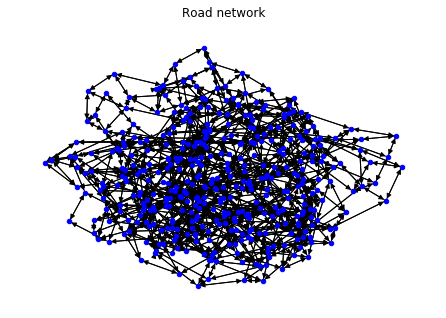

In [643]:
graph = generate_2D_graph(20)
pos = nx.spring_layout(graph, iterations=10)
nx.draw(graph, pos, node_color='b', node_size=20, with_labels=False)
plt.title("Road network")
plt.show()

In [644]:
# graph = nx.grid_2d_graph(7,7)


# plt.figure(figsize=(15,15))    # pour définir la taille de la figure
# pos = nx.planar_layout(graph)
# nx.draw_networkx(graph,pos=pos,edge_color='black',width=1,linewidths=1,node_size=800,node_color='pink',alpha=0.9)
# plt.title("Road network")
# plt.axis('off')
# plt.show()


In [645]:
N = len(graph.nodes)
print("Nombre de noeuds :",len(graph.nodes))

Nombre de noeuds : 400


In [646]:
nb_riders = N
coef_growth = 1
dlimit = 0.2

In [647]:
%%time
tsa = TransportServiceAgent(0)
gen = GeneratorAgent(coef_growth,1,False,seed=42,limit_d=dlimit)
agentListTrans = [gen, tsa]
agentListTrans += generate_some_seeded_riders(nb_riders)
sma = SMA(agentListTrans, graph, verbose=False)
sma.run()

Finished in 1055 ticks
CPU times: user 41.5 s, sys: 0 ns, total: 41.5 s
Wall time: 41.5 s


In [648]:
wt_transition = sma.wt_collector
comp_transition = sma.compute_collector
move_transition = sma.move_collector
print("nombre d'agents total :",sma.agentList[-1].unique_id)
print("Temps moyen d'attente", round(wt_transition[-1],2), "ticks")
print("Temps moyen de calcul pour un agent passager",round(comp_transition[-1]*1000,2),"ms")
print("Nb mouvement moyen pour un agent passager",move_transition[-1])

nombre d'agents total : 5291
Temps moyen d'attente 73.97 ticks
Temps moyen de calcul pour un agent passager 0.32 ms
Nb mouvement moyen pour un agent passager 29.755


In [649]:
%%time
tsa = TransportServiceAgent(0)
gen = GeneratorAgent(coef_growth,1,False,seed=42,limit_d=dlimit)
agentListGreed = [gen, tsa]
agentListGreed += generate_some_seeded_riders(nb_riders, strat="greedy")
sma = SMA(agentListGreed, graph, verbose=False)
sma.run()


Finished in 951 ticks
CPU times: user 13.9 s, sys: 0 ns, total: 13.9 s
Wall time: 13.9 s


In [650]:
wt_greedy = sma.wt_collector
comp_greedy = sma.compute_collector
move_greedy = sma.move_collector

In [651]:
print("nombre d'agents total :",sma.agentList[-1].unique_id)
print("Temps moyen d'attente", wt_greedy[-1], "ticks")
print("Temps moyen de calcul pour un agent passager",round(comp_greedy[-1]*1000,2),"ms")
print("Nb mouvement moyen pour un agent passager",move_greedy[-1])

nombre d'agents total : 4821
Temps moyen d'attente 86.9 ticks
Temps moyen de calcul pour un agent passager 0.01 ms
Nb mouvement moyen pour un agent passager 13.6275


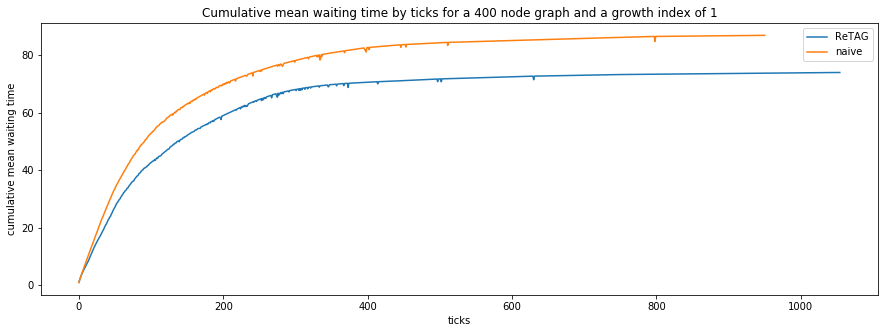

In [652]:
f = plt.figure(figsize=(15, 5))

plt.plot(wt_transition,label = 'ReTAG')
plt.plot(wt_greedy,label = 'naive')
plt.xlabel('ticks')
plt.ylabel('cumulative mean waiting time')
plt.title('Cumulative mean waiting time by ticks for a 400 node graph and a growth index of 1')
plt.legend()
plt.show()
#f.savefig("/home/fevrec/Documents/These/these/smac_agents/img/wt_trans_greedy_1000_1_250ticks", bbox_inches='tight')

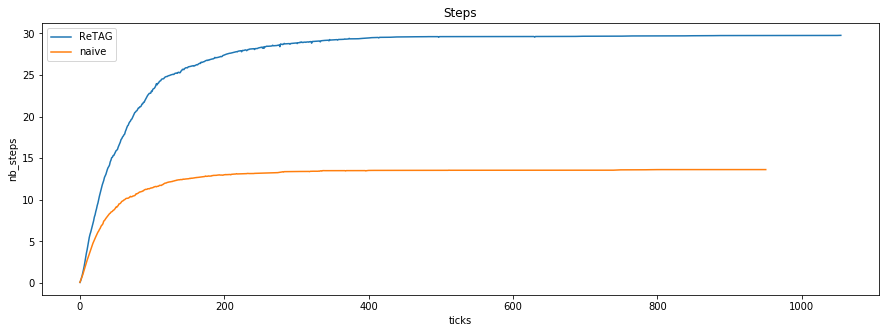

In [653]:
f = plt.figure(figsize=(15, 5))

plt.plot(move_transition,label = 'ReTAG')
plt.plot(move_greedy,label = 'naive')
plt.xlabel('ticks')
plt.ylabel('nb_steps')
plt.title('Steps')
plt.legend()
plt.show()
#f.savefig("/home/fevrec/Documents/These/these/smac_agents/img/wt_trans_greedy_1000_1_250ticks", bbox_inches='tight')

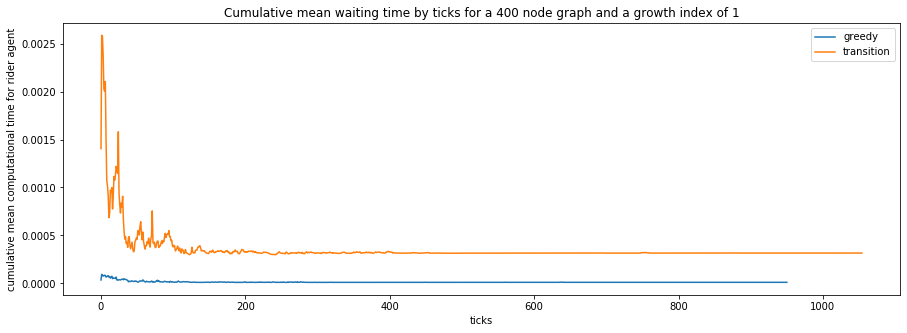

In [654]:
f = plt.figure(figsize=(15, 5))
plt.plot(comp_greedy,label = 'greedy')
plt.plot(comp_transition,label = 'transition')
plt.xlabel('ticks')
plt.ylabel('cumulative mean computational time for rider agent')
plt.title('Cumulative mean waiting time by ticks for a 400 node graph and a growth index of 1')
plt.legend()
plt.show()
#f.savefig("/home/fevrec/Documents/These/these/smac_agents/img/comp_trans_greedy_1000_1_250ticks", bbox_inches='tight')

In [655]:
print("Quand le système est stabilisé :")
p_wt = ((wt_transition[-1] - wt_greedy[-1])/wt_greedy[-1]) *100
print("On a donc une différence de",round(p_wt,1),"% du temps d'attente en utilisant notre méthode")
p_comp = ((comp_transition[-1] - comp_greedy[-1])/comp_greedy[-1]) *100
print("On a donc une différence de",round(p_comp,1),"% du temps d'execution en utilisant notre méthode")

Quand le système est stabilisé :
On a donc une différence de -14.9 % du temps d'attente en utilisant notre méthode
On a donc une différence de 2977.5 % du temps d'execution en utilisant notre méthode


In [656]:
print("Sur la totalité de la simulation (en moyenne) :")
p_wt = ((np.mean(wt_transition) - np.mean(wt_greedy))/np.mean(wt_greedy)) *100
print("On a donc une différence de",round(p_wt,1),"% du temps d'attente en utilisant notre méthode")
p_comp = ((np.mean(comp_transition) - np.mean(comp_greedy))/np.mean(comp_greedy)) *100
print("On a donc une différence de",round(p_comp,1),"% du temps d'execution en utilisant notre méthode")

Sur la totalité de la simulation (en moyenne) :
On a donc une différence de -13.8 % du temps d'attente en utilisant notre méthode
On a donc une différence de 2677.4 % du temps d'execution en utilisant notre méthode


### Comparaison temps d'éxécution et d'attente en fonction de la taille des instances

In [ ]:
import pandas as pd

In [330]:
# #constantes computuationelles
# type_graph = 'grid2D'
# nb_rep = 5
# taille_env = [3,5,10,12,15]
# #taille_env = [3,5,10,12,15,17,20,23,26,28,31]
# #taille_env = [3,5]
# strategies_env = ["greedy","transition"]
# d_limits = [0.25,0.5,0.75,1]
# #tick_nb = 250


# #stockage
# data = []

# #gathering datas
# for env in taille_env :
#     print("---Begin",env,"---\n")
#     graph = nx.grid_2d_graph(env,env)
#     for d_limit in d_limits:
#         for strat in strategies_env :
#             wt_tot = []
#             comp_tot = []
#             nb_agents_tot = []
#             nb_nodes_tot = []
#             for i in range(nb_rep):
#                 print("occur n°",i)
#                 tsa = TransportServiceAgent(0)
#                 gen = GeneratorAgent(1,1,True,strat)
#                 agentList = [gen, tsa]

#                 sma = SMA(agentList, graph)
#                 sma.run(250)
#                 wt_tot.append(np.mean(sma.wt_collector))
#                 comp_tot.append(np.mean(sma.compute_collector))
#                 nb_agents_tot.append(sma.agentList[-1].unique_id)
#                 nb_nodes_tot.append(len(graph.nodes))

#             #print("wt",wt_tot)
#             #print("comp",comp_tot)

#             data.append([type_graph, np.mean(nb_nodes_tot), np.mean(nb_agents_tot), d_limit, strat, tick_nb, np.nanmean(wt_tot), np.nanmean(comp_tot)])
#     print("---Ending",env,"---\n")

---Begin 3 ---

occur n° 0


NameError: name 'nb_nodes' is not defined

In [419]:
#constantes computuationelles
type_graph = 'grid2D'
nb_rep = 5
#taille_env = [3,5]
taille_env = [3,5,10,12,15,17,20,23,26,28,31]
#taille_env = [3,5]
strategies_env = ["greedy","transition"]
d_limits = [0.25,0.5,0.75,1]
seeds = [42,69,100,8,22]
#tick_nb = 250


#stockage
data = []

#gathering datas
for env in taille_env :
    print("---Begin",env,"---\n")
    graph = generate_2D_graph(env)
    #graph = nx.grid_2d_graph(env,env)
    for d_limit in d_limits:
        for strat in strategies_env :
            wt_tot = []
            comp_tot = []
            nb_agents_tot = []
            nb_nodes_tot = []
            nb_tick_tot = []
            i = 0
            for seed in seeds:
                i+=1
                print("occur n°",i)
#                 tsa = TransportServiceAgent(0)
#                 gen = GeneratorAgent(1,1,False,strat,d_limit)
#                 agentList = [gen, tsa]
                gen = GeneratorAgent(1,1,False,seed=seed,limit_d=d_limit)
                agentList = [gen, tsa]
                agentList += generate_some_seeded_riders(len(list(graph.nodes)),seed=seed,strat=strat)
                sma = SMA(agentList, graph)
                sma.run()
                wt_tot.append(np.mean(sma.wt_collector))
                comp_tot.append(np.mean(sma.compute_collector))
                nb_agents_tot.append(sma.agentList[-1].unique_id)
                nb_nodes_tot.append(len(graph.nodes))
                nb_tick_tot.append(sma.tick)

            #print("wt",wt_tot)
            #print("comp",comp_tot)

            data.append([type_graph, np.mean(nb_nodes_tot), np.mean(nb_agents_tot), d_limit, strat, np.mean(nb_tick_tot), np.nanmean(wt_tot), np.nanmean(comp_tot)])
    
    print("---Ending",env,"---\n")

---Begin 3 ---

occur n° 1
Finished in 154 ticks
occur n° 2
Finished in 243 ticks
occur n° 3
Finished in 309 ticks
occur n° 4
Finished in 284 ticks
occur n° 5
Finished in 289 ticks
occur n° 1
Finished in 154 ticks
occur n° 2
Finished in 243 ticks
occur n° 3
Finished in 309 ticks
occur n° 4
Finished in 284 ticks
occur n° 5
Finished in 289 ticks
occur n° 1
Finished in 60 ticks
occur n° 2
Finished in 44 ticks
occur n° 3
Finished in 47 ticks
occur n° 4
Finished in 159 ticks
occur n° 5
Finished in 18 ticks
occur n° 1
Finished in 60 ticks
occur n° 2
Finished in 44 ticks
occur n° 3
Finished in 65 ticks
occur n° 4
Finished in 123 ticks
occur n° 5
Finished in 86 ticks
occur n° 1
Finished in 60 ticks
occur n° 2
Finished in 27 ticks
occur n° 3
Finished in 39 ticks
occur n° 4
Finished in 39 ticks
occur n° 5
Finished in 71 ticks
occur n° 1
Finished in 60 ticks
occur n° 2
Finished in 52 ticks
occur n° 3
Finished in 74 ticks
occur n° 4
Finished in 39 ticks
occur n° 5
Finished in 97 ticks
occur n° 1
F

Finished in 503 ticks
occur n° 1
Finished in 698 ticks
occur n° 2
Finished in 510 ticks
occur n° 3
Finished in 772 ticks
occur n° 4
Finished in 639 ticks
occur n° 5
Finished in 515 ticks
occur n° 1
Finished in 283 ticks
occur n° 2
Finished in 284 ticks
occur n° 3
Finished in 325 ticks
occur n° 4
Finished in 506 ticks
occur n° 5
Finished in 374 ticks
occur n° 1
Finished in 217 ticks
occur n° 2
Finished in 225 ticks
occur n° 3
Finished in 387 ticks
occur n° 4
Finished in 195 ticks
occur n° 5
Finished in 241 ticks
occur n° 1
Finished in 155 ticks
occur n° 2
Finished in 285 ticks
occur n° 3
Finished in 203 ticks
occur n° 4
Finished in 178 ticks
occur n° 5
Finished in 253 ticks
occur n° 1
Finished in 181 ticks
occur n° 2
Finished in 234 ticks
occur n° 3
Finished in 195 ticks
occur n° 4
Finished in 280 ticks
occur n° 5
Finished in 188 ticks
occur n° 1
Finished in 206 ticks
occur n° 2
Finished in 154 ticks
occur n° 3
Finished in 202 ticks
occur n° 4
Finished in 165 ticks
occur n° 5
Finished i

In [420]:
data

[['grid2D',
  9.0,
  60.2,
  0.25,
  'greedy',
  255.8,
  74.40951989944699,
  4.83029841163047e-06],
 ['grid2D',
  9.0,
  60.2,
  0.25,
  'transition',
  255.8,
  73.13436218254562,
  2.7309526816561243e-05],
 ['grid2D',
  9.0,
  44.6,
  0.5,
  'greedy',
  65.6,
  17.789358910290936,
  5.18158884126502e-06],
 ['grid2D',
  9.0,
  50.8,
  0.5,
  'transition',
  75.6,
  16.72388419937555,
  3.794587046267088e-05],
 ['grid2D',
  9.0,
  54.0,
  0.75,
  'greedy',
  47.2,
  11.324150865146562,
  6.3762899611918925e-06],
 ['grid2D',
  9.0,
  72.0,
  0.75,
  'transition',
  64.4,
  14.020011734573592,
  3.885852439274578e-05],
 ['grid2D',
  9.0,
  57.0,
  1,
  'greedy',
  31.4,
  6.060569985569986,
  6.459630745784624e-06],
 ['grid2D',
  9.0,
  50.4,
  1,
  'transition',
  27.2,
  4.882246303079637,
  3.9124418858126406e-05],
 ['grid2D',
  25.0,
  202.2,
  0.25,
  'greedy',
  237.6,
  47.17425394285135,
  6.413548627031558e-06],
 ['grid2D',
  25.0,
  213.4,
  0.25,
  'transition',
  247.4,
  4

In [423]:
df = pd.DataFrame(data, columns=['graph_type', 'nb_nodes', 'nb_agents', 'max_prop_drivers', 'strategy', 'nb_ticks','mean_wt','mean_comp_time'])

In [426]:
df.to_csv("data_cor_17_06_20")

In [490]:
def get_means(entry, strat):
    a = list(df[df['strategy'] == strat][df['max_prop_drivers'] == 0.25][entry])
    b = list(df[df['strategy'] == strat][df['max_prop_drivers'] == 0.5][entry])
    c = list(df[df['strategy'] == strat][df['max_prop_drivers'] == 0.75][entry])
    d = list(df[df['strategy'] == strat][df['max_prop_drivers'] == 1][entry])
    return [(v + x + y + z)/4 for v, x, y, z in zip(a, b, c, d)]



In [514]:
def write_each_dlimit_for_entry(entry, dlimits, title, y_title, x_title='Number of nodes'):
    nb_nodes = df[df['strategy'] == 'greedy'][df['max_prop_drivers'] == 0.25]['nb_nodes']
    for dlimit in dlimits:
            f = plt.figure(figsize=(15, 5))
            data1 = list(df[df['strategy'] == 'greedy'][df['max_prop_drivers'] == dlimit][entry])
            data2 = list(df[df['strategy'] == 'transition'][df['max_prop_drivers'] == dlimit][entry])
            
            plt.plot(nb_nodes,data1, label='naive')
            plt.plot(nb_nodes,data2, label='ReTAG')
            plt.xlabel(x_title)
            plt.ylabel(y_title)
            plt.title(title+" with dlimit="+str(dlimit))
            plt.legend()
            plt.show()
            f.savefig("/home/fevrec/Documents/These/these/smac_agents/img/"+entry+"0_1000nodes_dlimit_"+str(dlimit).replace('.','_'), dpi=800, bbox_inches='tight')


/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


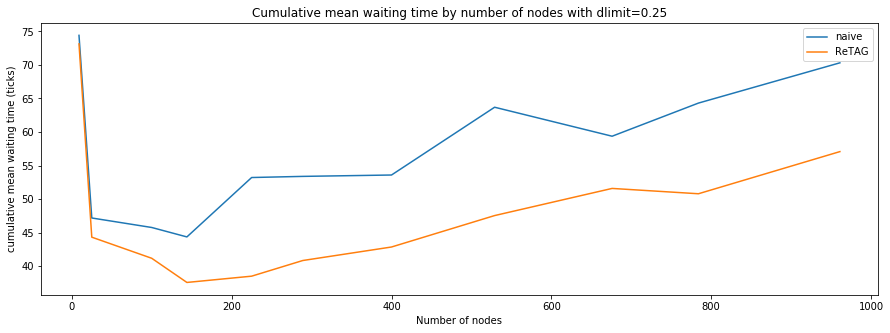

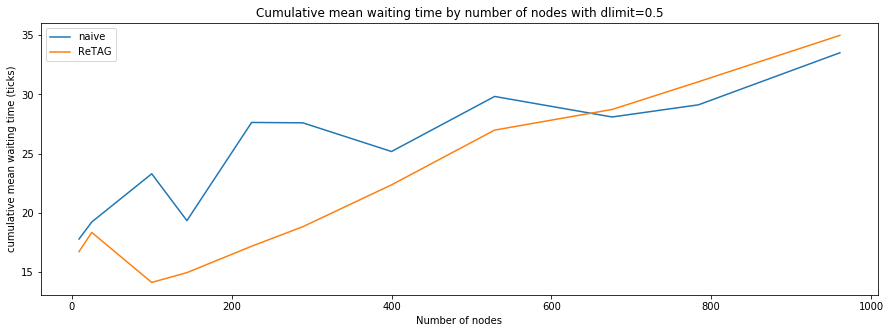

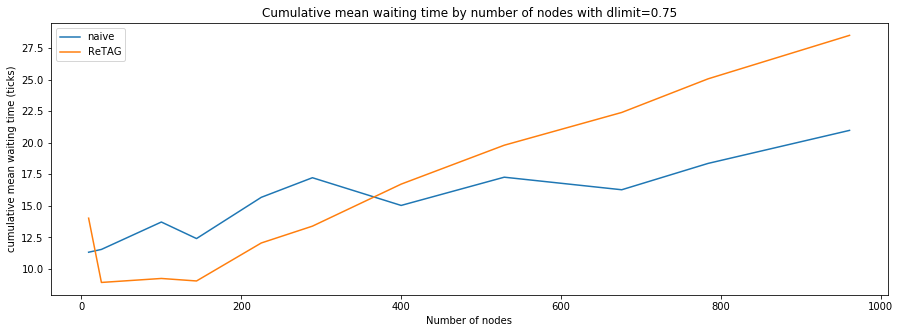

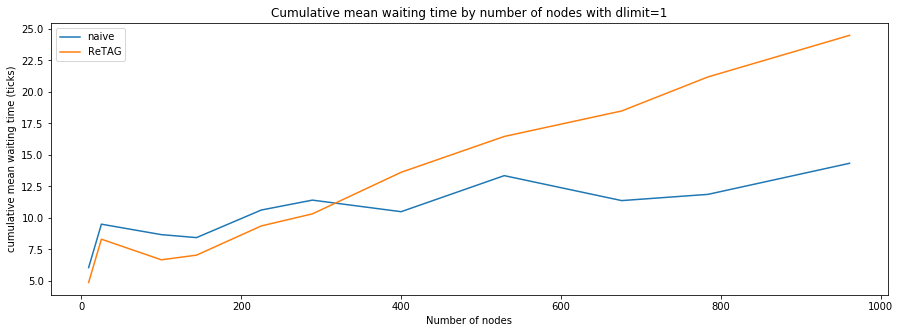

In [515]:
write_each_dlimit_for_entry("mean_wt",[0.25,0.5,0.75,1],"Cumulative mean waiting time by number of nodes", "cumulative mean waiting time (ticks)")

/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


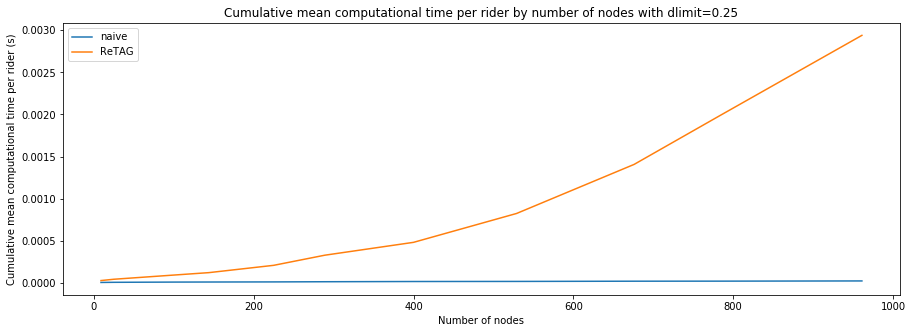

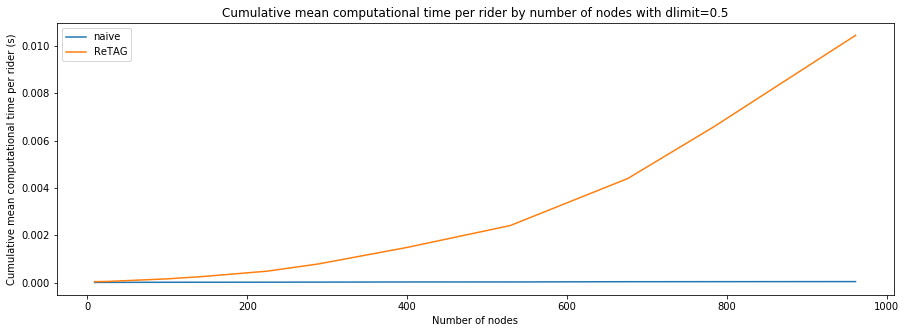

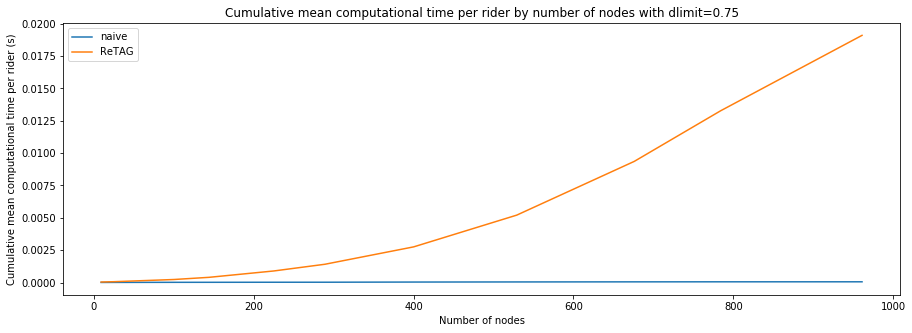

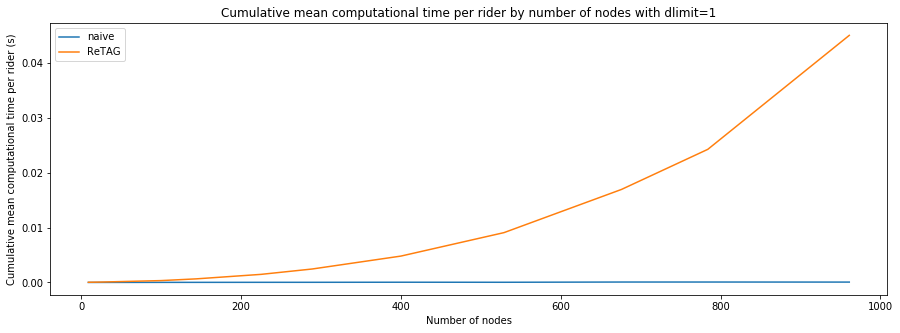

In [517]:
write_each_dlimit_for_entry("mean_comp_time",[0.25,0.5,0.75,1],"Cumulative mean computational time per rider by number of nodes", "Cumulative mean computational time per rider (s)")

/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


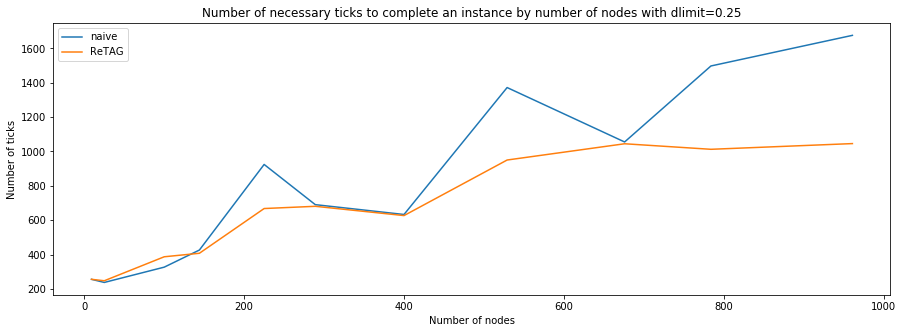

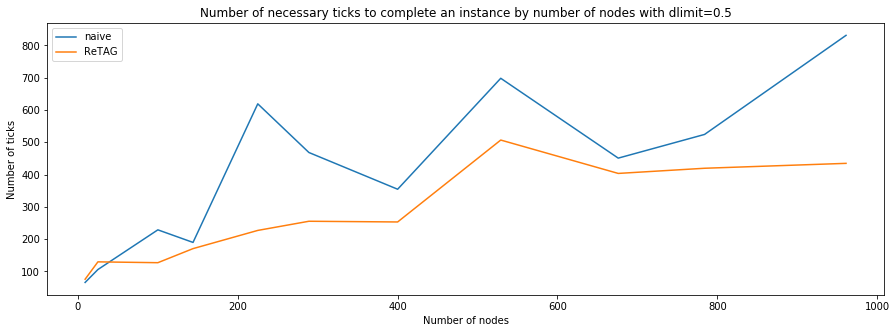

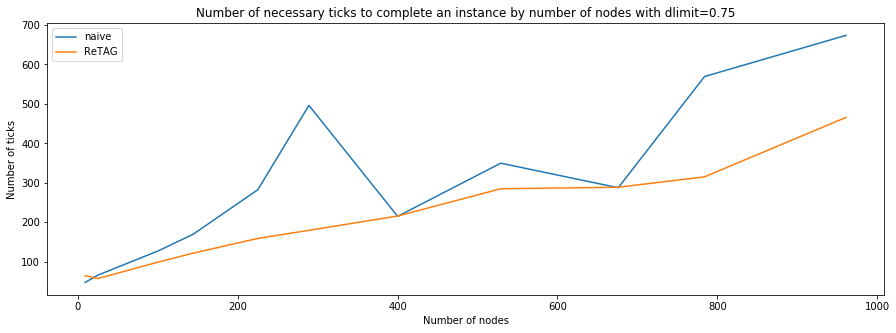

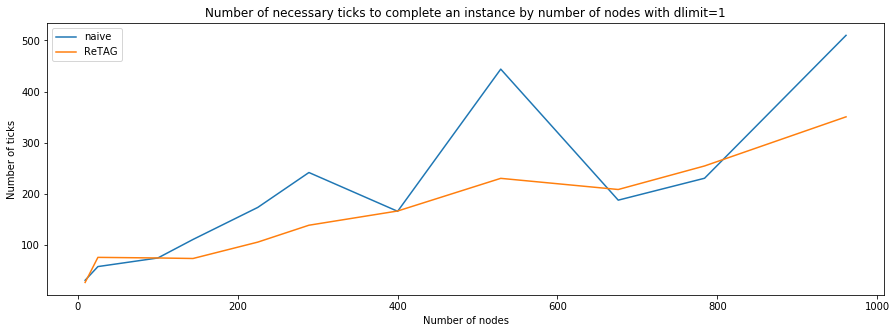

In [518]:
write_each_dlimit_for_entry("nb_ticks",[0.25,0.5,0.75,1],"Number of necessary ticks to complete an instance by number of nodes", "Number of ticks")

/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


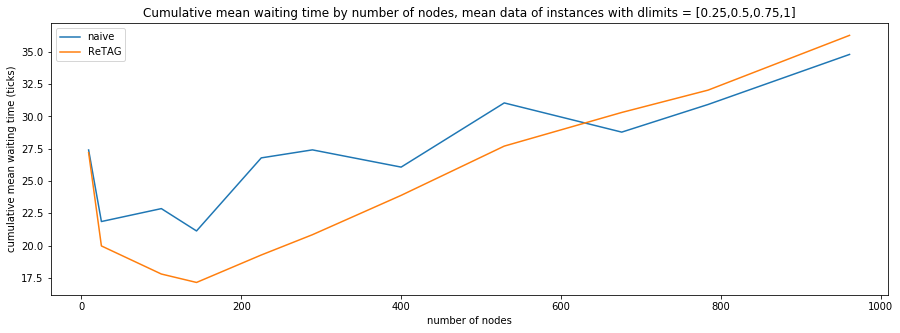

In [527]:
f = plt.figure(figsize=(15, 5))
greedy = df[df['strategy'] == 'greedy'][df['max_prop_drivers'] == 0.25]
trans =  df[df['strategy'] == 'transition'][df['max_prop_drivers'] == 0.25]
plt.plot(greedy['nb_nodes'],get_means('mean_wt','greedy'), label='naive')
plt.plot(trans['nb_nodes'],get_means('mean_wt','transition'), label='ReTAG')
plt.xlabel('number of nodes')
plt.ylabel('cumulative mean waiting time (ticks)')
plt.title('Cumulative mean waiting time by number of nodes, mean data of instances with dlimits = [0.25,0.5,0.75,1]')
plt.legend()
plt.show()
f.savefig("/home/fevrec/Documents/These/these/smac_agents/img/wt_0_1000nodes_alldlimits", dpi=800, bbox_inches='tight')

/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


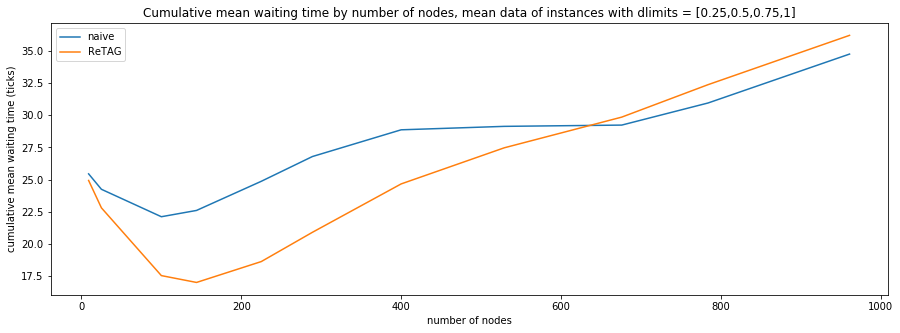

In [538]:
f = plt.figure(figsize=(15, 5))
greedy = df[df['strategy'] == 'greedy'][df['max_prop_drivers'] == 0.25]
trans =  df[df['strategy'] == 'transition'][df['max_prop_drivers'] == 0.25]

mean_t = get_means('mean_wt','transition')
poly_t = np.polyfit(nb_nodes,mean_t,5) 
poly_y_t = np.poly1d(poly_t)(nb_nodes) 

mean_g = get_means('mean_wt','greedy')
poly_g = np.polyfit(nb_nodes,mean_g,5) 
poly_y_g = np.poly1d(poly_g)(nb_nodes) 

plt.plot(greedy['nb_nodes'],poly_y_g, label='naive')
plt.plot(trans['nb_nodes'],poly_y_t, label='ReTAG')


plt.xlabel('number of nodes')
plt.ylabel('cumulative mean waiting time (ticks)')
plt.title('Cumulative mean waiting time by number of nodes, mean data of instances with dlimits = [0.25,0.5,0.75,1]')
plt.legend()
plt.show()
f.savefig("/home/fevrec/Documents/These/these/smac_agents/img/wt_0_1000nodes_alldlimits", dpi=800, bbox_inches='tight')

In [539]:
# f = plt.figure(figsize=(15, 5))
# greedy = df[df['strategy'] == 'greedy'][df['max_prop_drivers'] == 0.25]
# trans =  df[df['strategy'] == 'transition'][df['max_prop_drivers'] == 0.25]
# plt.plot(greedy['nb_nodes'],greedy['mean_wt'], label='naive')
# plt.plot(trans['nb_nodes'],trans['mean_wt'], label='ReTAG')
# plt.xlabel('number of nodes')
# plt.ylabel('cumulative mean waiting time (ticks)')
# plt.title('Cumulative mean waiting time by number of nodes')
# plt.legend()
# plt.show()
# #f.savefig("/home/fevrec/Documents/These/these/smac_agents/img/big_wt_trans_greedy_nbnodes_1_250ticks", bbox_inches='tight')

/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


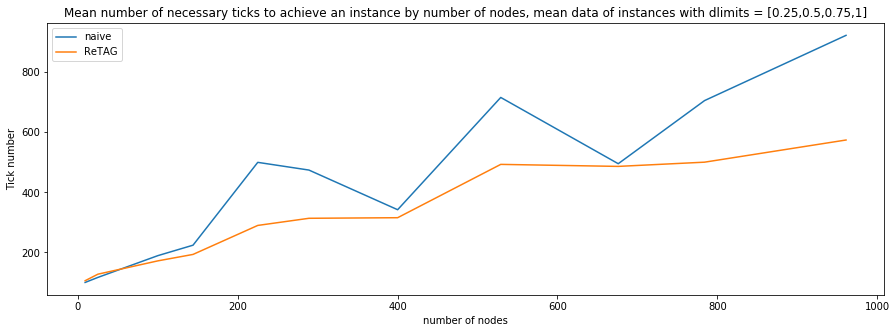

In [526]:
f = plt.figure(figsize=(15, 5))
greedy = df[df['strategy'] == 'greedy'][df['max_prop_drivers'] == 1]
trans =  df[df['strategy'] == 'transition'][df['max_prop_drivers'] == 1]
plt.plot(greedy['nb_nodes'],get_means('nb_ticks','greedy'), label='naive')
plt.plot(trans['nb_nodes'],get_means('nb_ticks','transition'), label='ReTAG')
plt.xlabel('number of nodes')
plt.ylabel('Tick number')
plt.title('Mean number of necessary ticks to achieve an instance by number of nodes, mean data of instances with dlimits = [0.25,0.5,0.75,1]')
plt.legend()
plt.show()
f.savefig("/home/fevrec/Documents/These/these/smac_agents/img/nb_ticks_0_1000nodes_alldlimits", dpi=800, bbox_inches='tight')

/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


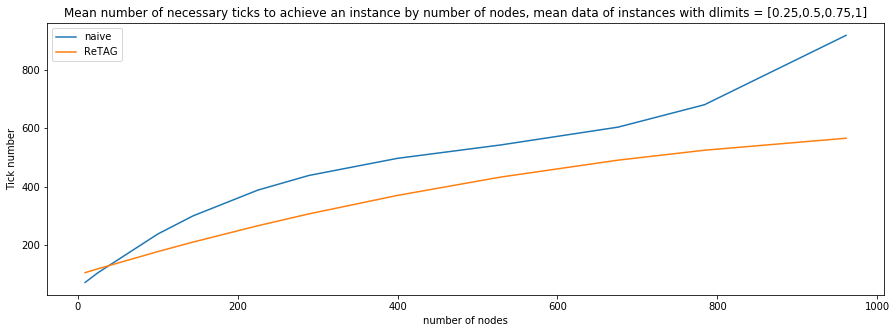

In [536]:
f = plt.figure(figsize=(15, 5))
greedy = df[df['strategy'] == 'greedy'][df['max_prop_drivers'] == 1]
trans =  df[df['strategy'] == 'transition'][df['max_prop_drivers'] == 1]
nb_nodes = greedy['nb_nodes']

mean_t = get_means('nb_ticks','transition')
poly_t = np.polyfit(nb_nodes,mean_t,3) 
poly_y_t = np.poly1d(poly_t)(nb_nodes) 

mean_g = get_means('nb_ticks','greedy')
poly_g = np.polyfit(nb_nodes,mean_g,3) 
poly_y_g = np.poly1d(poly_g)(nb_nodes) 


plt.plot(greedy['nb_nodes'],poly_y_g, label='naive')
plt.plot(trans['nb_nodes'],poly_y_t, label='ReTAG')
plt.xlabel('number of nodes')
plt.ylabel('Tick number')
plt.title('Mean number of necessary ticks to achieve an instance by number of nodes, mean data of instances with dlimits = [0.25,0.5,0.75,1]')
plt.legend()
plt.show()
f.savefig("/home/fevrec/Documents/These/these/smac_agents/img/nb_ticks_0_1000nodes_alldlimits", dpi=800, bbox_inches='tight')

/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


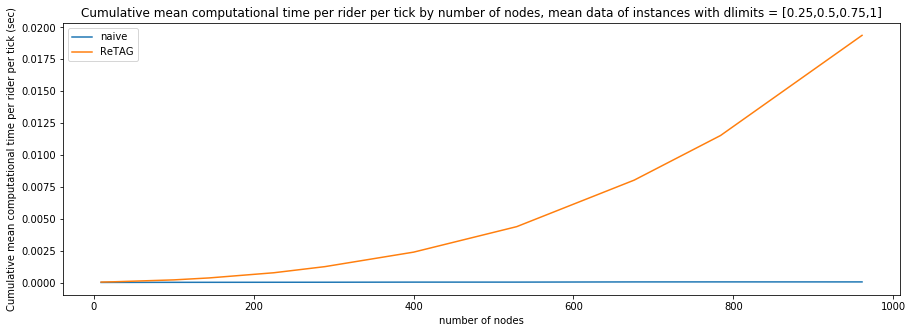

In [542]:
f = plt.figure(figsize=(15, 5))
greedy = df[df['strategy'] == 'greedy'][df['max_prop_drivers'] == 0.25]
trans =  df[df['strategy'] == 'transition'][df['max_prop_drivers'] == 0.25]
plt.plot(greedy['nb_nodes'],get_means('mean_comp_time','greedy'), label='naive')
plt.plot(trans['nb_nodes'],get_means('mean_comp_time','transition'), label='ReTAG')
plt.xlabel('number of nodes')
plt.ylabel("Cumulative mean computational time per rider per tick (sec)")
plt.title("Cumulative mean computational time per rider per tick by number of nodes, mean data of instances with dlimits = [0.25,0.5,0.75,1]")
plt.legend()
plt.show()
f.savefig("/home/fevrec/Documents/These/these/smac_agents/img/comp_0_1000nodes_alldlimits", dpi=800, bbox_inches='tight')

In [ ]:
df.to_csv("exp1.csv")

# OLD V1

In [ ]:
#     def generate_transition_graph(self):
#         G= nx.MultiDiGraph()
#         #print(self.Ats)
#         G.add_node(self.v_r, distance=0)
#         #il faudra se baser sur ad par la suite
#         for ats, val in self.Ats.items():
#             #print(ats, val)
#             #print(ats)
#             #print(G_ts.nodes())
#             if ats in self.Ad.keys():
#                  #G_ts.add_node(ats, distance=val['distance'])
#                 for ad in self.Ad[ats]:
#                     #print("coucou")
#                     #si le parcours est faisable
#                     #print(ad)
#                     d_time_left = ad[2]
#                     r_time_left = self.Ats[ats]['distance']
#                     d_trip = ad[1]
#                     if d_time_left >= r_time_left :
#                         if not (G.has_node(ats)):
#                             G.add_node(ats, distance=val['distance'])
                        
#                         if self.v_arr in ad[1]:
#                             new_node = self.v_arr
#                             d_subtrip_size = d_trip.index(self.v_arr)
#                             #dist = d_time_left + d_subtrip_size
#                         else :
#                             new_node = ad[1][-1]
#                             d_subtrip_size = len(ad[1]) - 1
#                             #id_d = ad[0]
#                             #TODO il manque qqchose, car si on se base sur le noeuds le plus eloigné il se peut que la contrib soit neg
#                             #alors qu'au final il peut quand meme nous faire gagner qqchose.
                            

#                         #dist : nombres de ticks minimum necessaires pour atteindre un noeuds
                        
#                         dist = d_time_left + d_subtrip_size
                        
#                         #dist = ((d_time_left + r_time_left) - (d_time_left - r_time_left)) + d_subtrip_size
                        
#                         if G.has_node(new_node):
#                             if (dist < G.nodes[new_node]['distance']):
#                                 G.nodes[new_node]['distance'] = dist
#                         else :
#                             G.add_node(new_node, distance=dist)
                        
                        
#                         contrib = nx.shortest_path_length(sma.graph, source=ats, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=new_node, target=self.v_arr)
#                         delay = d_time_left - r_time_left
#                         G.add_edge(ats, new_node, d=ad, contrib=contrib, delay=delay)
                    
#         self.G_ts = G

# def update_v1(self):
#         self.Ad = tsa.get_rider_matched_drivers(self.Av)
#         self.generate_transition_graph()
        
#         cur_node = self.v_r
        
#         blacklist = set()
#         #decision ici:
        
        
#         #si véhicule présent direct alors on effectue heuritique sinon reste sur son noeud et comportement dif
#         #manque un if ici
        
#         #if len([edge for edge in G_ts.out_edges(cur_node) if edge['d'][2]==0]) > 0:
#         if len(self.Ad[cur_node]) > 0 and len([driver for driver in self.Ad[cur_node] if driver[2]==0])>0:
#             best_driver = self.best_driver_contrib_and_wait()
#             #v_r = nouveau noeuds
#             #après decision
#             if best_driver != None :
                
#                 new_node = best_driver[1][1]
#                 #print("new_node",new_node)
#                 #cur_node = new_node
#                 print("Agent rider",self.unique_id,"move from",self.v_r,"to",new_node,"using car",best_driver)
#                 if new_node == self.v_arr:
#                     print("Rider n°",self.unique_id,"arrived with a waiting time of",self.wt,"ticks")
#                     self.is_alive = False
#                     return
#                 #on ecrase l'ancien noeud
#                 nx.relabel_nodes(self.G_ts, {cur_node:new_node}, copy=False)
#                 #G_ts.node[new_node] = G_ts[cur_node]
#                 #print(G_ts.node[new_node])
#                 #G_ts.add_edge(new_node, best_driver[1][-1])
#                 #G_ts.remove_node(cur_node)

#                 blacklist = set(cur_node)
#             else : 
#                 print("Agent rider",self.unique_id,"doesn't move")
#                 new_node = cur_node
#                 self.wt += 1
            
            
#         else:
#             print("Agent rider",self.unique_id,"doesn't move")
#             new_node = cur_node
#             self.wt += 1
        
        
#         self.Av = {new_node}
#         self.Ats = dict()
#         self.Ats[new_node] = {'distance':0}
#         #print("nodes in G_ts",self.G_ts.nodes())
#         other_nodes = [node for node in list(self.G_ts.nodes()) if node != new_node]
#         #print("other_nodes:",other_nodes)
#         for node in other_nodes:
#             #print("haspath_test between:",new_node,node)
#             if nx.has_path(self.G_ts,new_node,node):
#                 self.G_ts.node[node]['distance'] = self.G_ts.node[node]['distance'] - 1
#                 self.Ats[node] = {'distance': self.G_ts.node[node]['distance']}
#                 bl_node = nx.shortest_path(self.G_ts, new_node, node)[-2]
#                 edge_data = self.G_ts.get_edge_data(bl_node,node)
#                 #print(data)

#                     #si il y a plusieurs arretes menants au meme noeuds
#                     #on est dans un multigraph, donc on prends la meilleur edge
#                 #print("recup noeuds possibles, show edge",edge_data)
#                 for j in range(len(edge_data)): 
                   
#                     d = edge_data[j]['d']
#                     self.Av.union(set(d[1]))

#             else :
#                 blacklist.add(node)
#                 self.G_ts.remove_node(node)

#             #clean
#             #self.G_ts.remove_node(cur_node)
        
#         self.v_r = new_node
#         self.Av.difference(blacklist)
#         #print(self.Ats)

# OLD EXP

/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


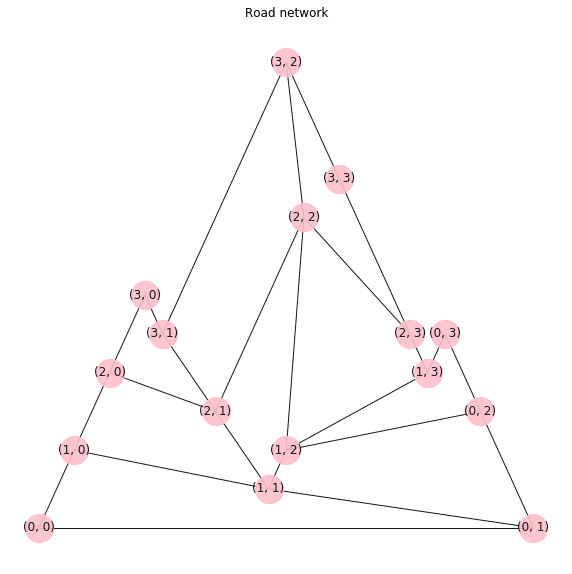

In [175]:
graph = nx.grid_2d_graph(4,4)


plt.figure(figsize=(10,10))    # pour définir la taille de la figure
pos = nx.planar_layout(graph)
nx.draw_networkx(graph,pos=pos,edge_color='black',width=1,linewidths=1,node_size=800,node_color='pink',alpha=0.9)
plt.title("Road network")
plt.axis('off')
plt.show()


In [176]:
node_list = list(graph.nodes)
trip1 = nx.shortest_path( graph, random.choice(node_list), random.choice(node_list))
trip2 = nx.shortest_path( graph, (1, 3), (1, 0))
print(trip2)
trip3 = nx.shortest_path( graph, (1, 0), (2, 3))
trip4 = list(((2,2),(1,2),(0,2),(1,1)))
trip5 = list(((3,2),(2,2),(2,3),(1,3),(0,3),(0,2)))
print("\n trip1:",trip1,"\n trip2:",trip2,"\n trip3:",trip3,"\n trip4:",trip4, "\n trip5:",trip5 )

[(1, 3), (1, 2), (1, 1), (1, 0)]

 trip1: [(0, 3), (1, 3), (2, 3), (3, 3), (3, 2)] 
 trip2: [(1, 3), (1, 2), (1, 1), (1, 0)] 
 trip3: [(1, 0), (1, 1), (1, 2), (1, 3), (2, 3)] 
 trip4: [(2, 2), (1, 2), (0, 2), (1, 1)] 
 trip5: [(3, 2), (2, 2), (2, 3), (1, 3), (0, 3), (0, 2)]


In [177]:
tsa = TransportServiceAgent(0)
agentList = [tsa,RiderAgent(7,(1, 1),(1, 3)),RiderAgent(6,(2, 2),(2, 3)), DriverAgent(1, trip1), DriverAgent(2, trip2), DriverAgent(3, trip3), DriverAgent(4, trip4), DriverAgent(5, trip5)]

sma = SMA(agentList, graph, verbose=True)
sma.runOnce()

Agent rider 7 doesn't move
Agent rider 6 move from (2, 2) to (1, 2) using car (4, [(2, 2), (1, 2), (0, 2), (1, 1)], 0)
tick 1 ended


In [178]:
# tsa = TransportServiceAgent(0)
# agentList = [tsa]
# node_list = list(graph.nodes)
# nb_riders = 5
# nb_drivers = 500
# id_count = 1
# for i in range(nb_riders):
#     n1, n2 = random.sample(node_list,2)    
#     r = RiderAgent(id_count, n1, n2)
#     agentList.append(r)
#     r.to_string()
#     id_count+=1
    
# for i in range(nb_drivers):
#     n1, n2 = random.sample(node_list,2) 
#     trip = nx.shortest_path(graph, n1, n2)
#     d = DriverAgent(id_count, trip)
#     d.to_string()
#     agentList.append(d)
#     id_count+=1
    

    
# sma = SMA(agentList, graph)
# sma.run(10)

In [179]:
# for _ in range(1000):
#     agentList = []
#     node_list = list(graph.nodes)
#     nb_riders = 2
#     nb_drivers = 5
#     id_count = 0
#     for i in range(nb_riders):
#         n1, n2 = random.sample(node_list,2)    
#         r = RiderAgent(id_count, n1, n2)
#         agentList.append(r)
#         r.to_string()
#         id_count+=1

#     for i in range(nb_drivers):
#         n1, n2 = random.sample(node_list,2) 
#         trip = nx.shortest_path(graph, n1, n2)
#         d = DriverAgent(id_count, trip)
#         d.to_string()
#         agentList.append(d)
#         id_count+=1



#     sma = SMA(agentList, graph)
#     sma.run(5)

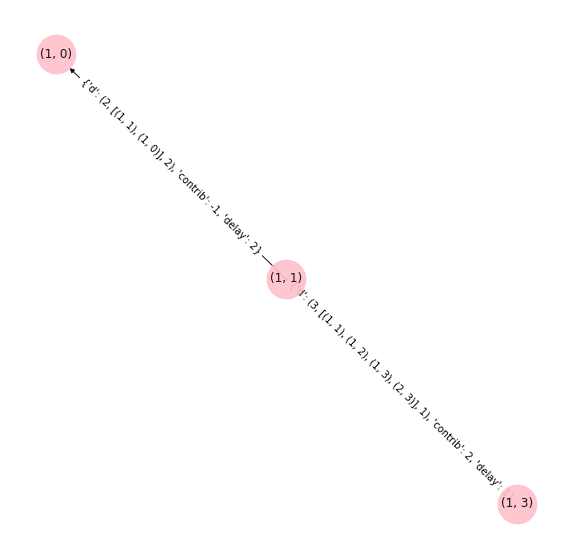

{(1, 1): 0, (1, 0): 5, (1, 3): 4}


In [180]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))    # pour définir la taille de la figure
G_ts = sma.agentList[1].G_ts
pos = nx.spring_layout(G_ts)
#labels = nx.get_node_attributes(G_ts, 'distance') 
nx.draw_networkx(G_ts,pos=pos, edge_color='black',width=1,linewidths=1,node_size=1500,node_color='pink',alpha=0.9)
nx.draw_networkx_edge_labels(G_ts,pos=pos)
#nx.draw_networkx_labels(G_ts,pos=nx.spring_layout(G_ts),labels=labels)
plt.axis('off')
plt.show()
print( nx.get_node_attributes(G_ts, 'distance') )

In [181]:
#sma = SMA(agentList, graph)
sma.runOnce()

Agent rider 7 move from (1, 1) to (1, 2) using car (3, [(1, 1), (1, 2), (1, 3), (2, 3)], 0)
Agent rider 6 doesn't move
tick 2 ended


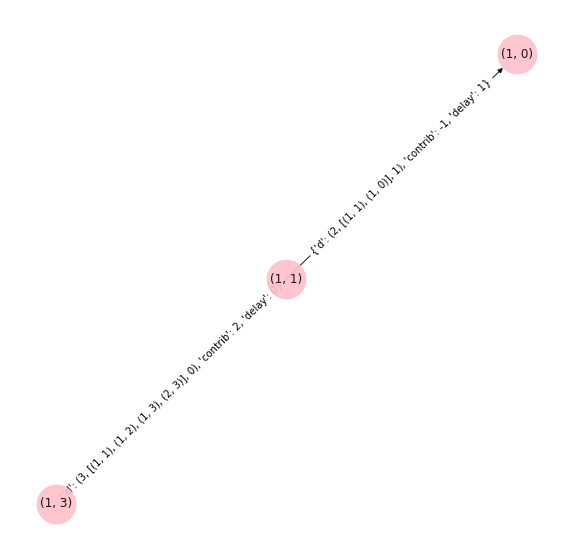

{(1, 1): 0, (1, 0): 3, (1, 3): 2}


In [182]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))    # pour définir la taille de la figure
G_ts = sma.agentList[1].G_ts
pos = nx.spring_layout(G_ts)
#labels = nx.get_node_attributes(G_ts, 'distance') 
nx.draw_networkx(G_ts,pos=pos, edge_color='black',width=1,linewidths=1,node_size=1500,node_color='pink',alpha=0.9)
nx.draw_networkx_edge_labels(G_ts,pos=pos)
#nx.draw_networkx_labels(G_ts,pos=nx.spring_layout(G_ts),labels=labels)
plt.axis('off')
plt.show()
print( nx.get_node_attributes(G_ts, 'distance') )

In [186]:
sma.runOnce()

Driver 1 arrived
Driver 3 arrived
tick 6 ended


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))    # pour définir la taille de la figure
G_ts = sma.agentList[1].G_ts
pos = nx.spring_layout(G_ts)
nx.draw_networkx(G_ts,pos=pos,edge_color='black',width=1,linewidths=1,node_size=800,node_color='pink',alpha=0.9)
nx.draw_networkx_edge_labels(G_ts,pos=pos)
plt.axis('off')
plt.show()


In [ ]:
def random_edge(graph, nb_edges, delete=True):
    '''
    Create a new random edge or delete one of its current edge if del_orig is True.
    :param graph: networkx graph
    :param del_orig: bool
    :return: networkx graph
    '''
    edges = list(graph.edges)
    nonedges = list(nx.non_edges(graph))

    # random edge choice
    
    

    if delete:
        # delete chosen edge
        chosen_edges = random.sample(edges, nb_edges)
        for edge in chosen_edges :
            graph.remove_edge(edge[0], edge[1])
    # add new edge
    else:
        chosen_nonedges = random.sample(nonedges, nb_edges)
        for non_edge in chosen_nonedges:
            graph.add_edge(non_edge[0], non_edge[1])

    return graph



In [ ]:
G = nx.grid_2d_graph(10, 10)  # 4x4 grid

random_edge(G, 20, delete=True)
pos = nx.spring_layout(G, iterations=100)

H = G.to_directed()
nx.draw(H, pos, node_color='b', node_size=20, with_labels=False)

plt.show()

In [ ]:
nx.draw(H, pos, node_color='b', node_size=20, with_labels=False)
#plt.figure(figsize=(10, 10))
#plt.show(block=False)
plt.savefig("Graph2.png", dpi=600, format="PNG")

Il a l'air de bien arriver à (1,3) donc ça marche pas trop mal, l'affichage est pourri par contre...

# Bibliographie

Philippe Mathieu, Yann Secq.
Environment Updating and Agent Scheduling Policies in Agent-based Simulators. 
ICAART Conference, 2012, pp 170-175

Philippe Mathieu, Sébastien Picault, Yann Secq.
Design Patterns for Environments in Multi-agent Simulations. 
PRIMA Conference, 2015, pp 678-686

Philippe Mathieu, Gildas Morvan, Sébastien Picault.
Multi-level agent-based simulations: Four design patterns. 
Journal of Simulation Modelling Practice and Theory, Janv 2018
